In [1]:
import jax
print(f"JAX devices: {jax.devices()}")
print(f"Backend: {jax.default_backend()}")
assert jax.default_backend() == "gpu", "gpu not detected!"


JAX devices: [CudaDevice(id=0)]
Backend: gpu


In [2]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "gpu")

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import jit

import jaxley as jx
from jaxley.channels import Na, K, Leak
from jaxley.synapses import IonotropicSynapse
from jaxley.connect import fully_connect, connect, sparse_connect

In [3]:
import os, json
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
# load data from grads notebook! 
def load_dataset(path="/n/home12/isanchez/jaxneuro/outputs/local_phys_dataset.npz"):
    d = np.load(path)
    out = {k: d[k] for k in d.files}
    for k in ("dt", "t_max", "i_delay", "i_dur", "N_trials", "Nsyn"):
        if k in out:
            out[k] = float(out[k]) if "." in str(out[k]) else int(out[k])
    return out

ds = load_dataset()

GRADS = ds["GRADS"]  # (N, Nsyn)
VLOCAL = ds["VLOCAL"]  # (N, Nsyn -1, T)
VSOMA = ds["VSOMA"]   # (N, T)
patterns = ds["patterns"] # (N, Nsyn)
losses = ds["losses"]  # (N,)
syn_post_comp_indices = ds["syn_post_comp_indices"]

dt = ds["dt"]
t_max = ds["t_max"]
i_delay = ds["i_delay"]
i_dur = ds["i_dur"]

N, Nsyn = GRADS.shape
T = VLOCAL.shape[2]
Nlocal = VLOCAL.shape[1]

# time axis
t = np.arange(T) * dt  # (T,)

# stimulus boolean mask
t_stim = (t >= i_delay) & (t <= i_delay + i_dur)


print(f"GRADS : {GRADS.shape}")
print(f"VLOCAL: {VLOCAL.shape}")
print(f"VSOMA : {VSOMA.shape}")
print(f"patterns:{patterns.shape}")
print(f"losses: {losses.shape}")
print(f"\n dt={dt} ms, t_max={t_max} ms,T={T} timepoints")
print(f"i_delay={i_delay} ms,i_dur={i_dur} ms")
print(f"stimulus window: {t_stim.sum()} timepoints "
      f"({t[t_stim][0]:.3f}–{t[t_stim][-1]:.3f} ms)")
print(f" N_trials={N},  Nsyn={Nsyn}")
print(f"syn_post_comp_indices = {syn_post_comp_indices}")

assert GRADS.shape == (N, Nsyn)
assert VLOCAL.shape == (N, Nsyn -1, T)
assert VSOMA.shape  == (N, T)
print("\nAll shape checks passed!!!")


GRADS : (500, 8)
VLOCAL: (500, 7, 2002)
VSOMA : (500, 2002)
patterns:(500, 8)
losses: (500,)

 dt=0.025 ms, t_max=50.0 ms,T=2002 timepoints
i_delay=3.0 ms,i_dur=2.0 ms
stimulus window: 81 timepoints (3.000–5.000 ms)
 N_trials=500,  Nsyn=8
syn_post_comp_indices = [ 0  2  4  6  8 10 12 14]

All shape checks passed!!!


## Step 7a: time correlation map

At each timepoint t and for each synapse, we can compute the Pearson correlation (across trials n) between a local signal $x_{n,i}(t)$ and the scalar gradient $g_{n,i}$ so that we have 

$$r_i(t) = \text{corr}_n\!\big(x_{n,i}(t),\; g_{n,i}\big)$$

and then aggregate $\overline{r^2}(t) = \text{mean}_i\, r_i(t)^2$


Becuase I have v_soma and v_local, I can compute the correlation with the gradient of v_local. And separetly do v_soma? Or does it make more sense to do all at once? 

In [ ]:
def time_resolved_corr(signal, grads):
    N, Nsyn, T = signal.shape
    assert grads.shape == (N, Nsyn), f"Expected grads {(N, Nsyn)}, got {grads.shape}"

    r_by_syn = np.zeros((Nsyn, T))
    for i in range(Nsyn):
        g_i = grads[:, i] # in R^N
        # vectorised pearson r across all timepoints at once
        # signal[:, i, :] is (N, T) — correlate each column with g_i
        x = signal[:, i, :]  # in R^N
        # demean
        x_dm = x - x.mean(axis=0, keepdims=True)
        g_dm = g_i - g_i.mean()
        num = (x_dm * g_dm[:, None]).sum(axis=0)          # (T,)
        denom = np.sqrt((x_dm**2).sum(axis=0) * (g_dm**2).sum()) + 1e-30 # want to prevent division by zero 
        r_by_syn[i] = num / denom # (Nsyn, T)
    return r_by_syn


GRADS_local = GRADS[:, 1:] 
r_vlocal = time_resolved_corr(VLOCAL, GRADS_local) # (Nsyn-1, T)
mean_r2_vlocal = (r_vlocal**2).mean(axis=0)  # (T,)
mean_r_vlocal = r_vlocal.mean(axis=0) # (T,)


## look at changes in voltage? 
dVdt = np.gradient(VLOCAL, dt, axis=2)  # (N, Nsyn, T)
r_dvdt = time_resolved_corr(dVdt, GRADS_local)  # (Nsyn-1, T)
mean_r2_dvdt = (r_dvdt**2).mean(axis=0) # (T,)
mean_r_dvdt = r_dvdt.mean(axis=0) # (T,)

print(f"r_vlocal shape: {r_vlocal.shape}")
print(f"mean_r2_vlocal shape: {mean_r2_vlocal.shape}")
print(f"r_dvdt shape: {r_dvdt.shape}")
print(f"mean_r2_dvdt shape: {mean_r2_dvdt.shape}")


r_vlocal shape: (7, 2002)
mean_r2_vlocal shape: (2002,)
r_dvdt shape: (7, 2002)
mean_r2_dvdt shape: (2002,)


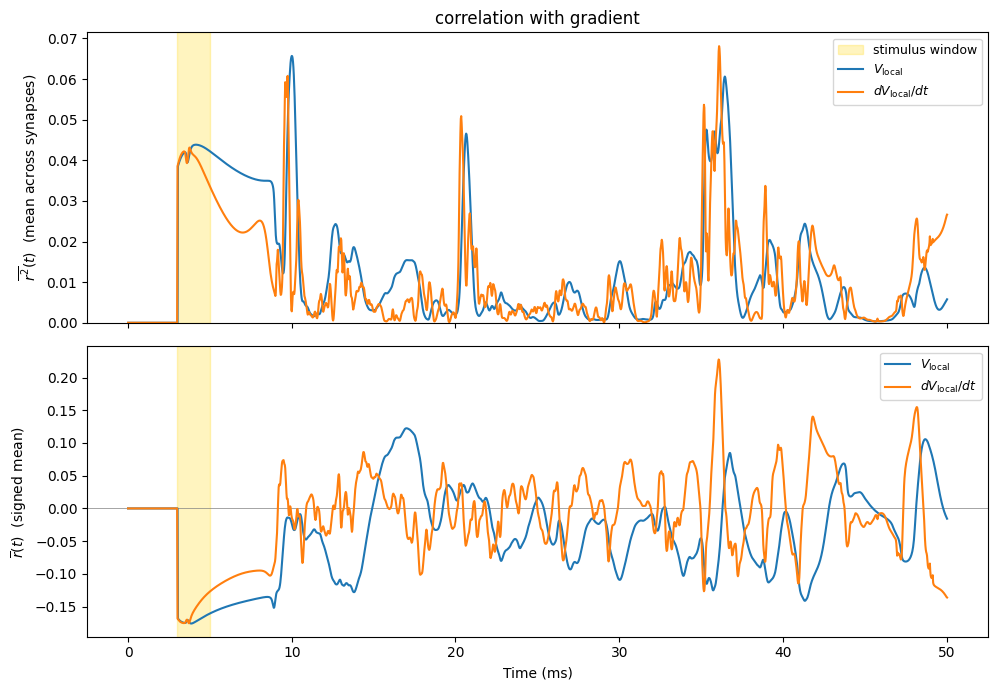

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True)

ax = axes[0]
ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.25, label="stimulus window")
ax.plot(t, mean_r2_vlocal, label=r"$V_{\rm local}$", lw=1.5)
ax.plot(t, mean_r2_dvdt,   label=r"$dV_{\rm local}/dt$", lw=1.5)
ax.set_ylabel(r"$\overline{r^2}(t)$  (mean across synapses)")
ax.set_title("correlation with gradient")
ax.legend(fontsize=9)
ax.set_ylim(bottom=0)

ax = axes[1]
ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.25)
ax.axhline(0, color="grey", lw=0.5)
ax.plot(t, mean_r_vlocal, label=r"$V_{\rm local}$", lw=1.5)
ax.plot(t, mean_r_dvdt,   label=r"$dV_{\rm local}/dt$", lw=1.5)
ax.set_ylabel(r"$\overline{r}(t)$  (signed mean)")
ax.set_xlabel("Time (ms)")
ax.legend(fontsize=9)

plt.tight_layout()
plt.show()


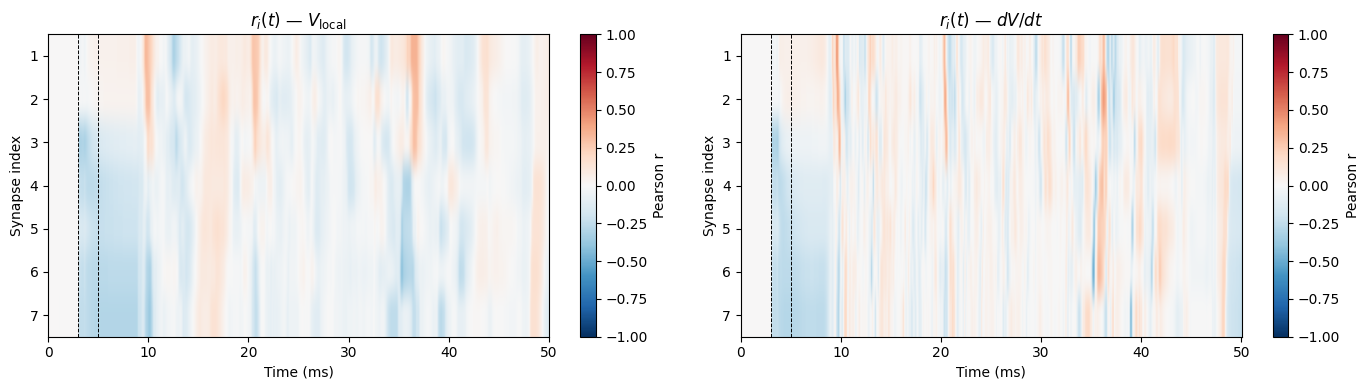

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

syn_start = 1                      # because VLOCAL corresponds to syn 1..Nsyn-1
Ns = r_vlocal.shape[0]             # == Nsyn-1
syn_end = syn_start + Ns - 1       # == Nsyn-1

for ax, data, title in zip(
    axes,
    [r_vlocal, r_dvdt],
    [r"$r_i(t)$ — $V_{\rm local}$", r"$r_i(t)$ — $dV/dt$"],
):
    im = ax.imshow(
        data,
        aspect="auto",
        cmap="RdBu_r",
        vmin=-1, vmax=1,
        extent=[t[0], t[-1], syn_end + 0.5, syn_start - 0.5],  # <-- updated
    )
    ax.axvline(i_delay, color="k", ls="--", lw=0.7)
    ax.axvline(i_delay + i_dur, color="k", ls="--", lw=0.7)
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Synapse index")
    ax.set_title(title)
    plt.colorbar(im, ax=ax, label="Pearson r")

plt.tight_layout()
plt.show()

In [ ]:
save_A = os.path.join("/n/home12/isanchez/jaxneuro/outputs", "analysis_stepA.npz")
np.savez(
    save_A,
    r_vlocal=r_vlocal,          # (Nsyn, T)
    mean_r2_vlocal=mean_r2_vlocal,  # (T,)
    mean_r_vlocal=mean_r_vlocal,
    r_dvdt=r_dvdt,
    mean_r2_dvdt=mean_r2_dvdt,
    mean_r_dvdt=mean_r_dvdt,
    t=t,
)
print(f"✓ Step A saved → {save_A}  ({os.path.getsize(save_A)/1e3:.1f} kB)")


✓ Step A saved → /n/home12/isanchez/jaxneuro/outputs/analysis_stepA.npz  (338.1 kB)


So far just seems to be the case that the strongest possible predictive time is really early like near stimulus onset(or like the initial polarization)

also seems to be something happening later on, but not sure how to quantify? maybe more spiking/bAP? 


synapse specific credits vs global effect? I wonder if this is where you do off vs on diagonals? how to zone inmore to bap times etc